In [1]:
import pandas as pd
import gensim
import numpy as np
from sklearn.model_selection import KFold
import nltk
from nltk.corpus import stopwords
# Import textblob
from textblob import Word, TextBlob
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore")

# lean_proteins

## Data Preprocessing

In [2]:
df = pd.read_excel('Meals_w_Goals_deid_snapshot.xlsx', 'lean_proteins')

In [3]:
df['meal_ingredients'].isnull().sum()

8

In [4]:
df = df.dropna(axis=0, subset=['meal_ingredients'])

In [5]:
df['meal_ingredients'].isnull().sum()

0

In [6]:
df['meal_ingredients'] = df['meal_ingredients'].astype(str)

In [7]:
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yashjain/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yashjain/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
def preprocess_meals(meal):
    processed_meal = meal
    processed_meal.replace('[^\w\s]', '')
    processed_meal = " ".join(word for word in processed_meal.split() if word not in stop_words)
    #processed_meal = " ".join(word for word in processed_meal.split() if word not in custom_stopwords)
    processed_meal = " ".join(Word(word).lemmatize() for word in processed_meal.split())
    return(processed_meal)

In [9]:
from sklearn.preprocessing import OrdinalEncoder
label = df['expert_assessment']
enc = OrdinalEncoder(categories = [['not_really', 'yes']])
df['expert_assessment'] = enc.fit_transform(label.to_numpy().reshape(-1,1))

In [10]:
total = df['expert_assessment'].count()
negative = df['expert_assessment'][df['expert_assessment']==0].count()
positive = df['expert_assessment'][df['expert_assessment']==1].count()
print('Total observations:', total)
print('Total negative labels:', negative)
print('Total positive labels:', positive)

Total observations: 1505
Total negative labels: 936
Total positive labels: 569


# TFIDF


## Meal Ingredients

In [11]:
df['meal_ingredients'] = df['meal_ingredients'].apply(lambda x: preprocess_meals(x))

In [12]:
df['meal_ingredients']

0       Chicken enchilada, cheese, sour cream, rice, corn
1                                Oatmeal brown sugar milk
2                                                  Cheese
3       Kraft deluxe Mac n cheese and. Mussels butter ...
4            Muffin bagel cream cheese jelly orange apple
                              ...                        
1508    Chicken patty, wholewheat wrap ,mozzarella cheese
1509    Bowl oatmeal, 2 x hard-boiled egg 16 oz bottle...
1510                                              Oatmeal
1511    Whiting fish sandwich 1 x tablespoon tartar ho...
1512    Bowl Minestrone soup, 2 x slice whole wheat br...
Name: meal_ingredients, Length: 1505, dtype: object

In [132]:
document = []
for i in df['meal_ingredients']:
    if i != '':
        document.append(i)

In [133]:
document

['Chicken enchilada, cheese, sour cream, rice, corn',
 'Oatmeal brown sugar milk',
 'Cheese',
 'Kraft deluxe Mac n cheese and. Mussels butter garlic sauce',
 'Muffin bagel cream cheese jelly orange apple',
 'Chocolate wip cream',
 'Strawberrys',
 'Dark chocolate ,oats',
 'Corn ,sweet potato',
 'Ice cream chocolate',
 'Cheeses noddle meat tomato sauce corn cob butter',
 'Strawberry',
 'Beef, white rice, green beans, potatoes, carrots, onion',
 'Broccoli ,onion,& vegetable noddle',
 'Bun cheese meat fry',
 'Rice salad steak',
 'Handful grape 1 banana',
 'Salad pork chop',
 'Beef Macaroni & Cheese',
 'Spinach onion feta cheese',
 'Oatmeal kiwi',
 'Plum',
 'Spinach, zucchini, turkey, sauce vegetable spaghetti',
 '1 slice cheddar potato bread fair amount cream cheese',
 'Corn rice cheese',
 'Brockley spinach cheese etc',
 '99% fat free yogurt peach bottom',
 'Spaghetti meat sauce',
 'Rice bean salad pork shoulder',
 'Bacon',
 'Corn',
 'Pineapples',
 'Strawberry, whole grain wheat, oats, bar

In [134]:
data_X = np.squeeze(pd.DataFrame(df['meal_ingredients']))
data_y = np.squeeze(pd.DataFrame(df['expert_assessment']))

In [135]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)

In [136]:
print(X_train.shape, X_test.shape)

(1204,) (301,)


In [151]:
train_accuracy = []
test_accuracy = []
for i in range(1000):
    data_X = np.squeeze(pd.DataFrame(df['meal_ingredients']))
    data_y = np.squeeze(pd.DataFrame(df['expert_assessment']))
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)
    tfidf = TfidfVectorizer(max_features=100, lowercase=True, analyzer='word',
                        stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
    train = tfidf.fit_transform(X_train)
    test = tfidf.transform(X_test)
    lr = LogisticRegression()
    #scores = cross_val_score(lr, train, y_train, cv=3)
    y_pred_train = cross_val_predict(lr, train, y_train, cv=3)
    #y_pred_test = cross_val_predict(lr, test, y_test, cv=3)
    lr.fit(train, y_train)
    #y_pred_train = lr.predict(train)
    y_pred_test = lr.predict(test)
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))


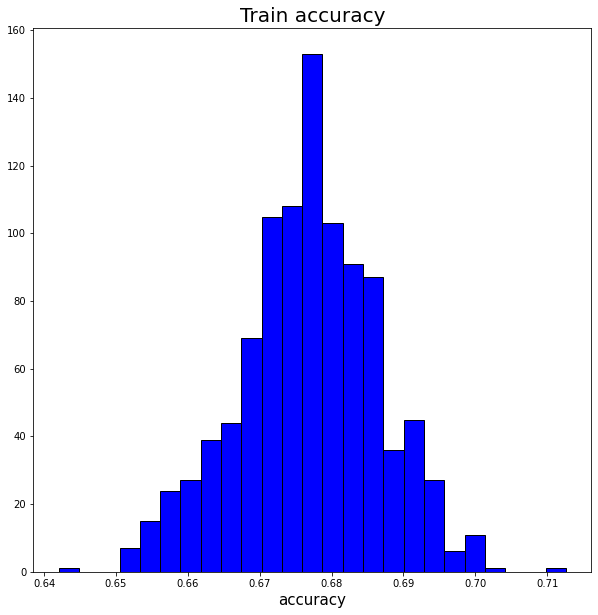

In [152]:
plt.figure(figsize=(10,10))  
plt.hist(train_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('Train accuracy', size = 20)
plt.xlabel('accuracy', size = 15)

plt.show()

In [168]:
print(np.mean(train_accuracy))
print(np.std(train_accuracy))

0.6718205980066445
0.010904452628089308


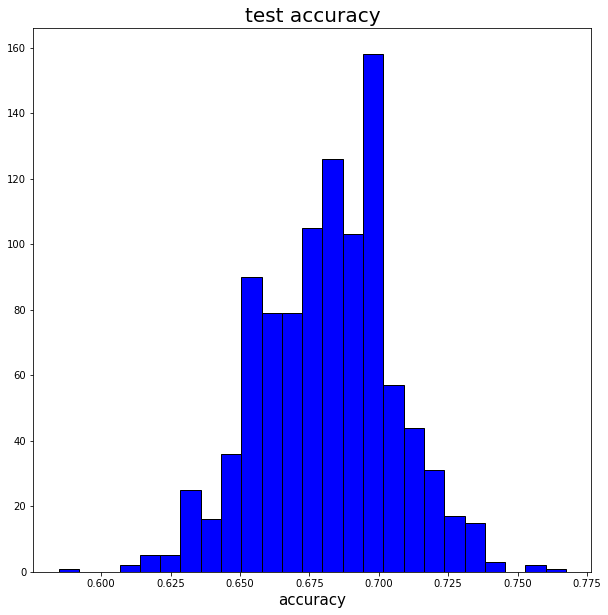

In [153]:
plt.figure(figsize=(10,10))  
plt.hist(test_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('test accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [169]:
print(np.mean(test_accuracy))
print(np.std(test_accuracy))

0.6774252491694353
0.02419781188589416


# TFIDF Meal Title

In [171]:
df['meal_title'].isnull().sum()

0

In [172]:
df['meal_title'] = df['meal_title'].astype(str)

In [173]:
df = df.dropna(axis=0, subset=['meal_title'])

In [174]:
df['meal_title'].isnull().sum()

0

In [175]:
document = []
for i in df['meal_title']:
    if i != '':
        document.append(i)

In [176]:
data_X = np.squeeze(pd.DataFrame(df['meal_title']))
data_y = np.squeeze(pd.DataFrame(df['expert_assessment']))

In [177]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)

In [178]:
print(X_train.shape, X_test.shape)

(1204,) (301,)


In [179]:
train_accuracy = []
test_accuracy = []
for i in range(1000):
    data_X = np.squeeze(pd.DataFrame(df['meal_title']))
    data_y = np.squeeze(pd.DataFrame(df['expert_assessment']))
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)
    tfidf = TfidfVectorizer(max_features=100, lowercase=True, analyzer='word',
                        stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
    train = tfidf.fit_transform(X_train)
    test = tfidf.transform(X_test)
    lr = LogisticRegression()
    #scores = cross_val_score(lr, train, y_train, cv=3)
    y_pred_train = cross_val_predict(lr, train, y_train, cv=3)
    #y_pred_test = cross_val_predict(lr, test, y_test, cv=3)
    lr.fit(train, y_train)
    #y_pred_train = lr.predict(train)
    y_pred_test = lr.predict(test)
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))

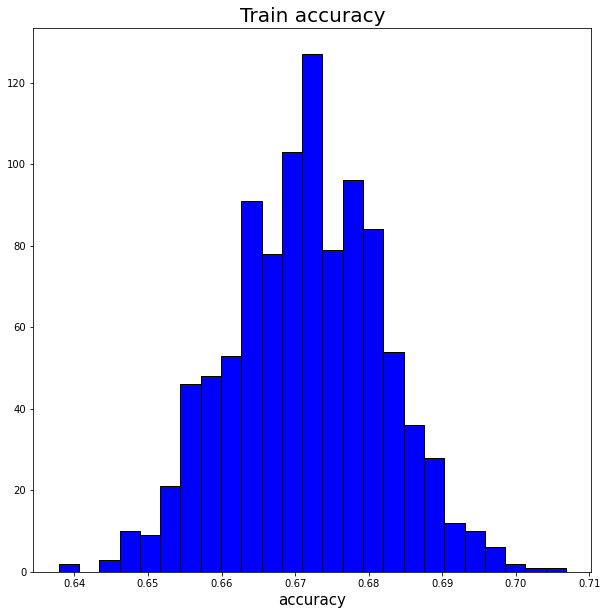

In [180]:
plt.figure(figsize=(10,10))  
plt.hist(train_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('Train accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [182]:
print(np.mean(train_accuracy))
print(np.std(train_accuracy))

0.6715764119601328
0.010300139123952735


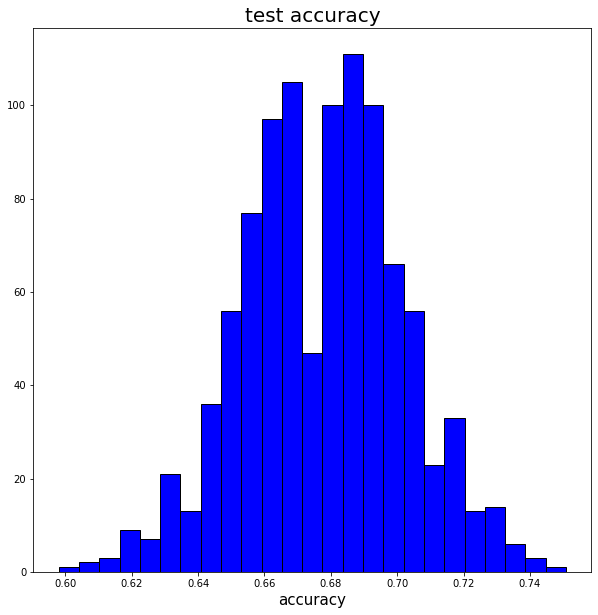

In [181]:
plt.figure(figsize=(10,10))  
plt.hist(test_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('test accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [183]:
print(np.mean(test_accuracy))
print(np.std(test_accuracy))

0.6775847176079735
0.023901522510831396


# TFIDF Ingredients + Title

In [187]:
df['ingredients_and_title'] = df['meal_ingredients'].astype(str) +' '+ df['meal_title'].astype(str)

In [188]:
document = []
for i in df['ingredients_and_title']:
    if i != '':
        document.append(i)

In [186]:
document

['Chicken enchilada, cheese, sour cream, rice, corn Lean cuisine',
 'Oatmeal brown sugar milk oatmeal',
 'Cheese Eggs and bacon',
 'Kraft deluxe Mac n cheese and. Mussels butter garlic sauce Mac n cheese and mussels',
 'Muffin bagel cream cheese jelly orange apple Morning snack',
 'Chocolate wip cream Sugar free Chocolate pudding and low fat wip cream',
 'Strawberrys Strawberrys',
 'Dark chocolate ,oats Kind bar',
 'Corn ,sweet potato Mash potatoes corn and steak',
 'Ice cream chocolate Reduced fat ice cream bar',
 'Cheeses noddle meat tomato sauce corn cob butter Ziti',
 'Strawberry Jello',
 'Beef, white rice, green beans, potatoes, carrots, onion Beef stew',
 'Broccoli ,onion,& vegetable noddle Chicken Alfredo Pasta',
 'Bun cheese meat fry Cheeseburger cranberry juice fries',
 'Rice salad steak Rice  salad and steak',
 'Handful grape 1 banana Banana and grapes',
 'Salad pork chop Salad and pork chops',
 'Beef Macaroni & Cheese 2022-07-27 00:00:00',
 'Spinach onion feta cheese Omelett

In [191]:
data_X = np.squeeze(pd.DataFrame(df['ingredients_and_title']))
data_y = np.squeeze(pd.DataFrame(df['expert_assessment']))

In [192]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)

In [193]:
print(X_train.shape, X_test.shape)

(1204,) (301,)


In [194]:
train_accuracy = []
test_accuracy = []
for i in range(1000):
    data_X = np.squeeze(pd.DataFrame(df['ingredients_and_title']))
    data_y = np.squeeze(pd.DataFrame(df['expert_assessment']))
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)
    tfidf = TfidfVectorizer(max_features=100, lowercase=True, analyzer='word',
                        stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
    train = tfidf.fit_transform(X_train)
    test = tfidf.transform(X_test)
    lr = LogisticRegression()
    #scores = cross_val_score(lr, train, y_train, cv=3)
    y_pred_train = cross_val_predict(lr, train, y_train, cv=3)
    #y_pred_test = cross_val_predict(lr, test, y_test, cv=3)
    lr.fit(train, y_train)
    #y_pred_train = lr.predict(train)
    y_pred_test = lr.predict(test)
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))


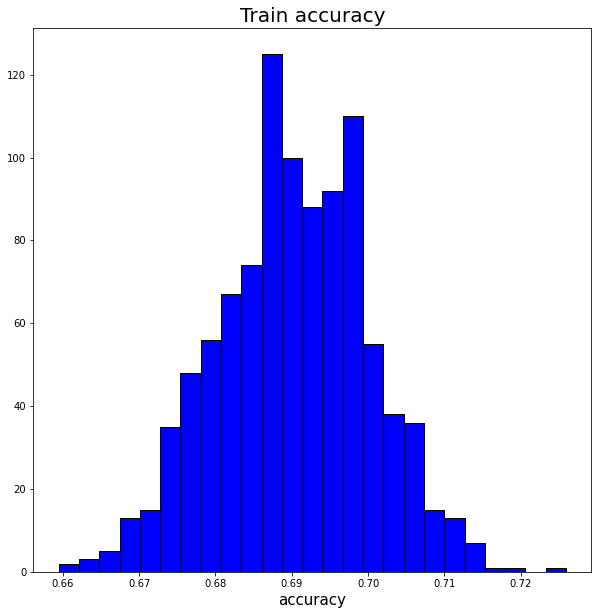

In [195]:
plt.figure(figsize=(10,10))  
plt.hist(train_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('Train accuracy', size = 20)
plt.xlabel('accuracy', size = 15)

plt.show()

In [196]:
print(np.mean(train_accuracy))
print(np.std(train_accuracy))

0.6901918604651163
0.010002459624830966


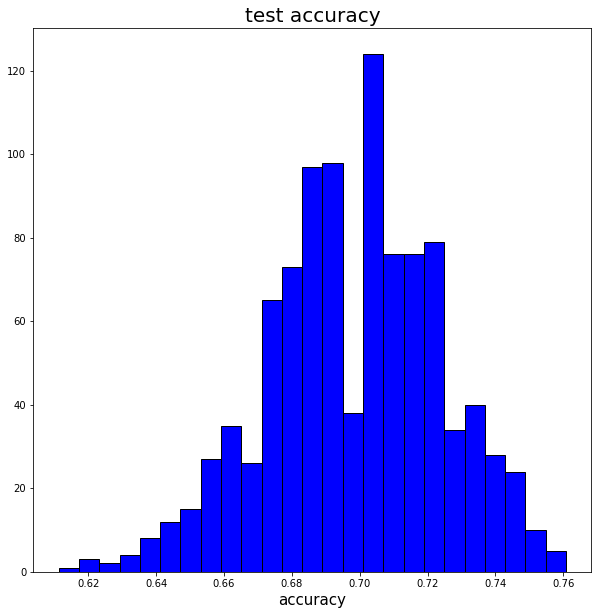

In [197]:
plt.figure(figsize=(10,10))  
plt.hist(test_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('test accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [198]:
print(np.mean(test_accuracy))
print(np.std(test_accuracy))

0.6978305647840531
0.02576856731756272


# Word2vec

## ingredients

In [200]:
df['meal_ingredients'] = df['meal_ingredients'].apply(lambda x: preprocess_meals(x))

In [201]:
meal_ingredients = df.meal_ingredients.apply(gensim.utils.simple_preprocess)

In [202]:
meal_ingredients

0       [chicken, enchilada, cheese, sour, cream, rice...
1                           [oatmeal, brown, sugar, milk]
2                                                [cheese]
3       [kraft, deluxe, mac, cheese, and, mussels, but...
4       [muffin, bagel, cream, cheese, jelly, orange, ...
                              ...                        
1508    [chicken, patty, wholewheat, wrap, mozzarella,...
1509    [bowl, oatmeal, hard, boiled, egg, oz, bottle,...
1510                                            [oatmeal]
1511    [whiting, fish, sandwich, tablespoon, tartar, ...
1512    [bowl, minestrone, soup, slice, whole, wheat, ...
Name: meal_ingredients, Length: 1505, dtype: object

In [203]:
embeddings = gensim.models.Word2Vec(
        window = 1,
        min_count = 1,
        workers = 1)

embeddings.build_vocab(meal_ingredients, progress_per = 100)

embeddings.train(meal_ingredients, total_examples = embeddings.corpus_count, epochs = 5)
learned_words_meal_ingredients = embeddings.wv.index_to_key

In [204]:
learned_words_meal_ingredients

['chicken',
 'oz',
 'cheese',
 'cup',
 'rice',
 'water',
 'egg',
 'bread',
 'tomato',
 'white',
 'onion',
 'salad',
 'pepper',
 'lettuce',
 'bottle',
 'wheat',
 'corn',
 'whole',
 'sauce',
 'milk',
 'beef',
 'coffee',
 'turkey',
 'banana',
 'black',
 'eggs',
 'red',
 'broccoli',
 'bean',
 'sugar',
 'beans',
 'potato',
 'spinach',
 'sandwich',
 'butter',
 'carrots',
 'bacon',
 'pork',
 'organic',
 'fish',
 'soup',
 'green',
 'onions',
 'peppers',
 'fried',
 'vegetable',
 'boiled',
 'tbsp',
 'cheddar',
 'slice',
 'hard',
 'cream',
 'ham',
 'sausage',
 'brown',
 'oil',
 'oatmeal',
 'orange',
 'salt',
 'yogurt',
 'almond',
 'fry',
 'garlic',
 'apple',
 'steak',
 'half',
 'salmon',
 'cucumber',
 'tablespoon',
 'tomatoes',
 'breast',
 'strawberry',
 'carrot',
 'potatoes',
 'tspn',
 'raisin',
 'meat',
 'tuna',
 'ground',
 'roast',
 'pineapple',
 'raw',
 'noodle',
 'dressing',
 'mixed',
 'tea',
 'fat',
 'bun',
 'cereal',
 'sweet',
 'chocolate',
 'pasta',
 'tbsps',
 'cinnamon',
 'spaghetti',
 '

In [205]:
words = []
for i in meal_ingredients:
    temp = []
    for j in i:
        if j in learned_words_meal_ingredients:
            temp.append(j)
        else:
            print(i)
    words.append(temp)

In [206]:
l = []
eg = 0
for i in range(len(words)):
        if len(words[i])>=1:
            a = np.mean(embeddings.wv[words[i]], axis=0)
            l.append(a)
        else:
            l.append(np.asarray(100 * [0]))

In [207]:
data_y = np.squeeze(data_y)
data_y.shape

(1505,)

In [208]:
data_X = pd.DataFrame(l)
data_X.shape

(1505, 100)

In [209]:
train_accuracy = []
test_accuracy = []
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)
#     tfidf = TfidfVectorizer(max_features=100, lowercase=True, analyzer='word',
#                         stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
#     train = tfidf.fit_transform(X_train)
#     test = tfidf.transform(X_test)
    lr = LogisticRegression()
    #scores = cross_val_score(lr, train, y_train, cv=3)
    y_pred_train = cross_val_predict(lr, X_train, y_train, cv=3)
    #y_pred_test = cross_val_predict(lr, test, y_test, cv=3)
    lr.fit(X_train, y_train)
    #y_pred_train = lr.predict(train)
    y_pred_test = lr.predict(X_test)
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))

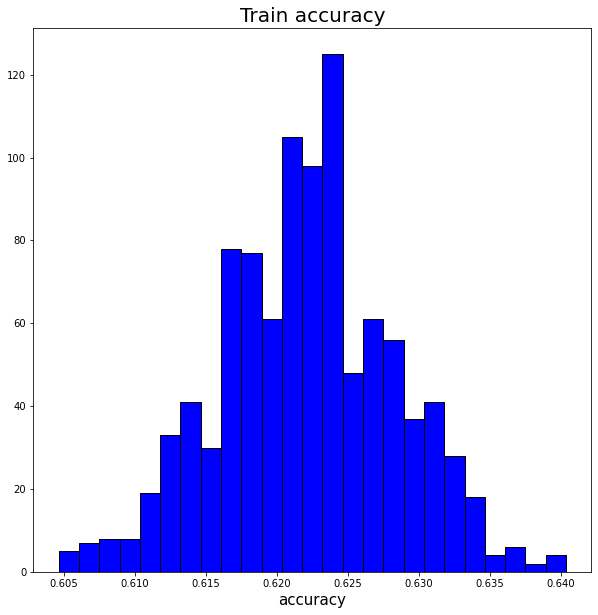

In [210]:
plt.figure(figsize=(10,10))  
plt.hist(train_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('Train accuracy', size = 20)
plt.xlabel('accuracy', size = 15)

plt.show()

In [211]:
print(np.mean(train_accuracy))
print(np.std(train_accuracy))

0.6220980066445182
0.006152347403388435


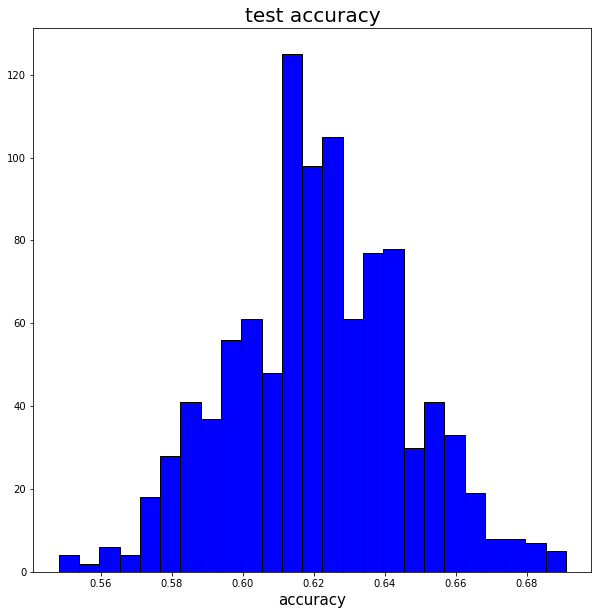

In [212]:
plt.figure(figsize=(10,10))  
plt.hist(test_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('test accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [213]:
print(np.mean(test_accuracy))
print(np.std(test_accuracy))

0.6212425249169434
0.024609389613553745


## title

In [256]:
df['meal_title'].isnull().sum()

0

In [257]:
df['meal_title'] = df['meal_title'].astype(str)

In [258]:
df = df.dropna(axis=0, subset=['meal_title'])

In [259]:
df['meal_title'].isnull().sum()

0

In [260]:
meal_title = df.meal_title.apply(gensim.utils.simple_preprocess)

In [261]:
meal_title

0                                         [lean, cuisine]
1                                               [oatmeal]
2                                      [eggs, and, bacon]
3                             [mac, cheese, and, mussels]
4                                        [morning, snack]
                              ...                        
1508          [chicken, parmesan, with, wholewheat, wrap]
1509    [bowl, of, oatmeal, hard, boiled, eggs, and, b...
1510                                             [cereal]
1511    [whiting, fish, sandwich, and, bottle, of, water]
1512    [minestrone, soup, whole, wheat, bread, and, w...
Name: meal_title, Length: 1505, dtype: object

In [262]:
embeddings = gensim.models.Word2Vec(
        window = 1,
        min_count = 1,
        workers = 1)

embeddings.build_vocab(meal_title, progress_per = 100)

embeddings.train(meal_title, total_examples = embeddings.corpus_count, epochs = 5)
learned_words_meal_title = embeddings.wv.index_to_key

In [263]:
learned_words_meal_title

['and',
 'chicken',
 'water',
 'rice',
 'with',
 'of',
 'salad',
 'cheese',
 'eggs',
 'sandwich',
 'bottle',
 'coffee',
 'egg',
 'beans',
 'bread',
 'dinner',
 'lunch',
 'orange',
 'juice',
 'banana',
 'beef',
 'toast',
 'turkey',
 'fish',
 'soup',
 'breakfast',
 'cup',
 'boiled',
 'smoothie',
 'milk',
 'hard',
 'white',
 'black',
 'oatmeal',
 'apple',
 'yogurt',
 'whole',
 'oz',
 'omelette',
 'fries',
 'pork',
 'broccoli',
 'corn',
 'salmon',
 'potatoes',
 'bar',
 'cereal',
 'sausage',
 'breast',
 'steak',
 'tuna',
 'wheat',
 'bacon',
 'tomato',
 'carrots',
 'grapes',
 'vegetables',
 'roast',
 'meatballs',
 'cream',
 'mixed',
 'potato',
 'spaghetti',
 'raisin',
 'butter',
 'fried',
 'stew',
 'lettuce',
 'pasta',
 'onions',
 'sweet',
 'ham',
 'baked',
 'protein',
 'red',
 'yellow',
 'roll',
 'on',
 'crackers',
 'veg',
 'food',
 'almond',
 'peppers',
 'tomatoes',
 'fruit',
 'ginger',
 'greek',
 'mac',
 'bran',
 'curry',
 'grain',
 'pear',
 'pizza',
 'peas',
 'scrambled',
 'fry',
 'noodl

In [264]:
words = []
for i in meal_title:
    temp = []
    for j in i:
        if j in learned_words_meal_title:
            temp.append(j)
        else:
            print(i)
    words.append(temp)

In [265]:
l = []
for i in range(len(words)):
        if len(words[i])>=1:
            a = np.mean(embeddings.wv[words[i]], axis=0)
            l.append(a)
        else:
            l.append(np.asarray(100 * [0]))

In [266]:
data_y = np.squeeze(data_y)
data_y.shape

(1505,)

In [267]:
data_X = pd.DataFrame(l)
data_X.shape

(1505, 100)

In [268]:
train_accuracy = []
test_accuracy = []
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)
#     tfidf = TfidfVectorizer(max_features=100, lowercase=True, analyzer='word',
#                         stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
#     train = tfidf.fit_transform(X_train)
#     test = tfidf.transform(X_test)
    lr = LogisticRegression()
    #scores = cross_val_score(lr, train, y_train, cv=3)
    y_pred_train = cross_val_predict(lr, X_train, y_train, cv=3)
    #y_pred_test = cross_val_predict(lr, test, y_test, cv=3)
    lr.fit(X_train, y_train)
    #y_pred_train = lr.predict(train)
    y_pred_test = lr.predict(X_test)
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))

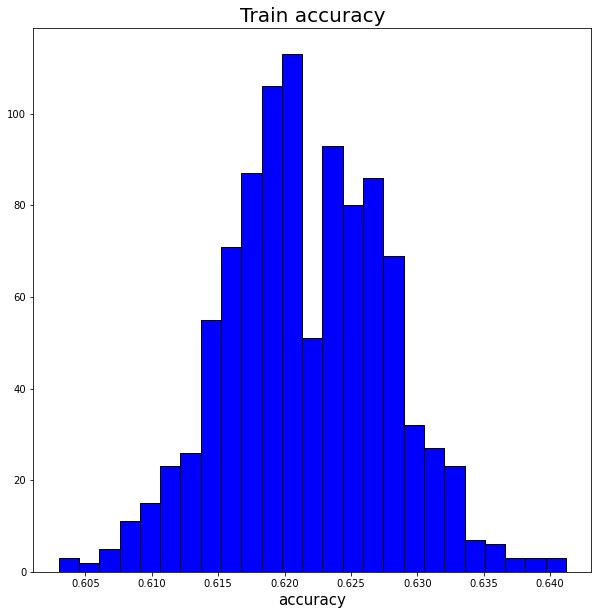

In [269]:
plt.figure(figsize=(10,10))  
plt.hist(train_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('Train accuracy', size = 20)
plt.xlabel('accuracy', size = 15)

plt.show()

In [270]:
print(np.mean(train_accuracy))
print(np.std(train_accuracy))

0.6216171096345515
0.006116514508471546


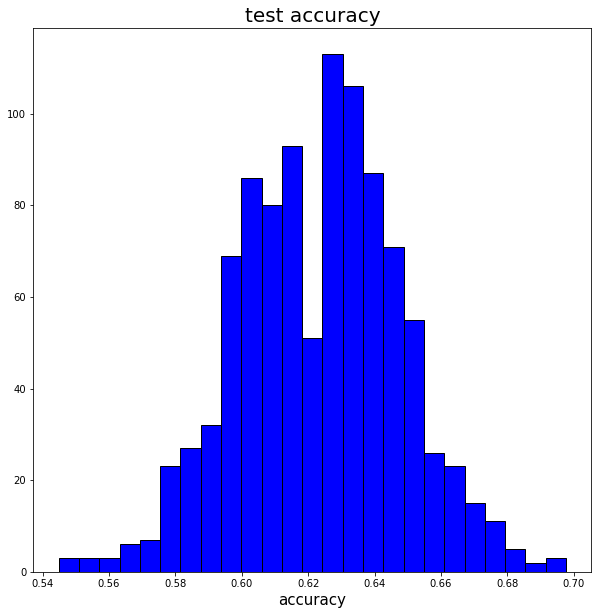

In [271]:
plt.figure(figsize=(10,10))  
plt.hist(test_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('test accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [272]:
print(np.mean(test_accuracy))
print(np.std(test_accuracy))

0.6231661129568106
0.02446605803388618


## ingredients_and_title

In [241]:
df['ingredients_and_title'] = df['meal_ingredients'].astype(str) +' '+ df['meal_title'].astype(str)

In [242]:
df['ingredients_and_title']

0       Chicken enchilada, cheese, sour cream, rice, c...
1                        Oatmeal brown sugar milk oatmeal
2                                   Cheese Eggs and bacon
3       Kraft deluxe Mac n cheese and. Mussels butter ...
4       Muffin bagel cream cheese jelly orange apple M...
                              ...                        
1508    Chicken patty, wholewheat wrap ,mozzarella che...
1509    Bowl oatmeal, 2 x hard-boiled egg 16 oz bottle...
1510                                       Oatmeal Cereal
1511    Whiting fish sandwich 1 x tablespoon tartar ho...
1512    Bowl Minestrone soup, 2 x slice whole wheat br...
Name: ingredients_and_title, Length: 1505, dtype: object

In [243]:
meal_ingredients_title = df.ingredients_and_title.apply(gensim.utils.simple_preprocess)

In [244]:
meal_ingredients_title

0       [chicken, enchilada, cheese, sour, cream, rice...
1                  [oatmeal, brown, sugar, milk, oatmeal]
2                              [cheese, eggs, and, bacon]
3       [kraft, deluxe, mac, cheese, and, mussels, but...
4       [muffin, bagel, cream, cheese, jelly, orange, ...
                              ...                        
1508    [chicken, patty, wholewheat, wrap, mozzarella,...
1509    [bowl, oatmeal, hard, boiled, egg, oz, bottle,...
1510                                    [oatmeal, cereal]
1511    [whiting, fish, sandwich, tablespoon, tartar, ...
1512    [bowl, minestrone, soup, slice, whole, wheat, ...
Name: ingredients_and_title, Length: 1505, dtype: object

In [245]:
embeddings = gensim.models.Word2Vec(
        window = 1,
        min_count = 1,
        workers = 1)

embeddings.build_vocab(meal_ingredients_title, progress_per = 100)

embeddings.train(meal_ingredients_title, total_examples = embeddings.corpus_count, epochs = 5)
learned_words_meal_ingredients_title = embeddings.wv.index_to_key

In [246]:
learned_words_meal_ingredients_title

['and',
 'chicken',
 'rice',
 'water',
 'cheese',
 'oz',
 'cup',
 'salad',
 'egg',
 'bread',
 'bottle',
 'eggs',
 'with',
 'tomato',
 'of',
 'coffee',
 'sandwich',
 'white',
 'beef',
 'beans',
 'lettuce',
 'corn',
 'whole',
 'wheat',
 'banana',
 'turkey',
 'onion',
 'milk',
 'pepper',
 'black',
 'sauce',
 'broccoli',
 'fish',
 'soup',
 'orange',
 'red',
 'potato',
 'boiled',
 'pork',
 'hard',
 'carrots',
 'bacon',
 'juice',
 'butter',
 'oatmeal',
 'sugar',
 'spinach',
 'toast',
 'yogurt',
 'apple',
 'sausage',
 'onions',
 'dinner',
 'cream',
 'bean',
 'salmon',
 'fried',
 'lunch',
 'peppers',
 'potatoes',
 'steak',
 'ham',
 'breast',
 'cereal',
 'tuna',
 'smoothie',
 'green',
 'cheddar',
 'almond',
 'organic',
 'roast',
 'vegetable',
 'fry',
 'mixed',
 'brown',
 'raisin',
 'breakfast',
 'tomatoes',
 'spaghetti',
 'sweet',
 'pasta',
 'tbsp',
 'slice',
 'half',
 'bar',
 'roll',
 'garlic',
 'fries',
 'tea',
 'oil',
 'curry',
 'yellow',
 'protein',
 'salt',
 'stew',
 'greek',
 'omelette',


In [247]:
words = []
for i in meal_ingredients_title:
    temp = []
    for j in i:
        if j in learned_words_meal_ingredients_title:
            temp.append(j)
        else:
            print(i)
    words.append(temp)

In [248]:
l = []
for i in range(len(words)):
        if len(words[i])>=1:
            a = np.mean(embeddings.wv[words[i]], axis=0)
            l.append(a)
        else:
            l.append(np.asarray(100 * [0]))

In [249]:
data_y = np.squeeze(data_y)
data_y.shape

(1505,)

In [250]:
data_X = pd.DataFrame(l)
data_X.shape

(1505, 100)

In [251]:
train_accuracy = []
test_accuracy = []
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)
#     tfidf = TfidfVectorizer(max_features=100, lowercase=True, analyzer='word',
#                         stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
#     train = tfidf.fit_transform(X_train)
#     test = tfidf.transform(X_test)
    lr = LogisticRegression()
    #scores = cross_val_score(lr, train, y_train, cv=3)
    y_pred_train = cross_val_predict(lr, X_train, y_train, cv=3)
    #y_pred_test = cross_val_predict(lr, test, y_test, cv=3)
    lr.fit(X_train, y_train)
    #y_pred_train = lr.predict(train)
    y_pred_test = lr.predict(X_test)
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))

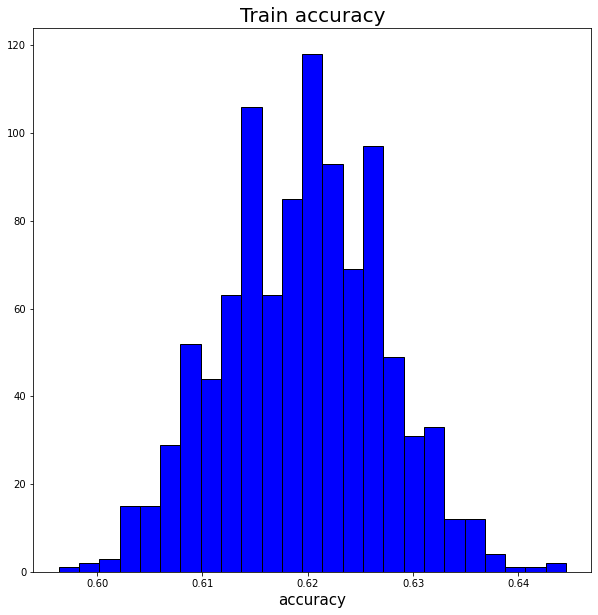

In [252]:
plt.figure(figsize=(10,10))  
plt.hist(train_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('Train accuracy', size = 20)
plt.xlabel('accuracy', size = 15)

plt.show()

In [253]:
print(np.mean(train_accuracy))
print(np.std(train_accuracy))

0.6194518272425249
0.007592089062805311


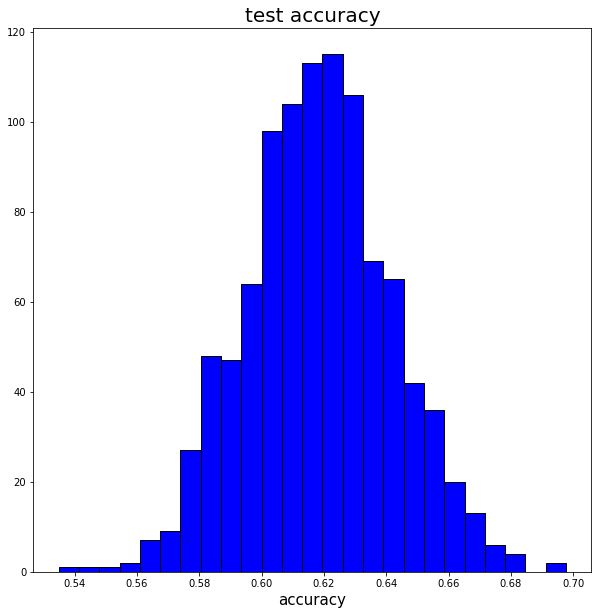

In [254]:
plt.figure(figsize=(10,10))  
plt.hist(test_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('test accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [255]:
print(np.mean(test_accuracy))
print(np.std(test_accuracy))

0.6185282392026576
0.023822166645135635
